<a href="https://colab.research.google.com/github/VusalIs/tensorflow-speech-recognition-challenge/blob/main/MS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download data and unzip it

Download the data zip file

In [ ]:
from google.colab import files
files.upload()
!pip install --upgrade --force-reinstall --no-deps kaggle
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c tensorflow-speech-recognition-challenge

Uzip the data

In [ ]:
!mkdir unzipped-data
!unzip /content/tensorflow-speech-recognition-challenge.zip -d /content/unzipped-data

Unzip training data

In [ ]:
!7z x /content/unzipped-data/train.7z

Unzip the test data

In [ ]:
!7z x /content/unzipped-data/test.7z

#Preprocessing

Import dependencies

In [ ]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode()
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

Take some random data audio to show general features

In [ ]:
train_audio_path = '/content/train/audio/'
filename = '/yes/004ae714_nohash_0.wav'
samples, sample_rate = librosa.load(str(train_audio_path)+filename)

In [ ]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [ ]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

Visualize Mel power spectrogram

In [ ]:
S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)

log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()


Visualize MFCC

In [ ]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

Let's listen to the audio

In [ ]:
ipd.Audio(samples, rate=sample_rate)

As you hear the pause is so much which makes training more difficult and It should take so much time. Let's see cutted version. The numbers are kind of random.

In [ ]:
samples_cut = samples[4000:20000]
ipd.Audio(samples_cut, rate=sample_rate)

The word still can be heard clearly. We can agree that the entire word can be heard. It is impossible to cut all the files manually and do this basing on the simple plot. But you can use for example webrtcvad package to have a good VAD.

Let's plot it again, together with guessed alignment of 'y' 'e' 's' graphems

In [ ]:
freqs, times, spectrogram_cut = log_specgram(samples_cut, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(samples_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.text(0.06, 1000, 'Y', fontsize=18)
ax2.text(0.17, 1000, 'E', fontsize=18)
ax2.text(0.36, 1000, 'S', fontsize=18)

xcoords = [0.025, 0.11, 0.23, 0.49]
for xc in xcoords:
    ax1.axvline(x=xc*16000, c='r')
    ax2.axvline(x=xc, c='r')

#Dataset Investigation

In [ ]:
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()
print('Number of labels: ' + str(len(dirs)))

In [ ]:
number_of_recordings = []
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    number_of_recordings.append(len(waves))

data = [go.Histogram(x=dirs, y=number_of_recordings)]
trace = go.Bar(
    x=dirs,
    y=number_of_recordings,
    marker=dict(color = number_of_recordings, colorscale='sunset', showscale=True),
)
layout = go.Layout(
    title='Number of recordings in given label',
    xaxis = dict(title='Words'),
    yaxis = dict(title='Number of recordings')
)

py.iplot(go.Figure(data=[trace], layout=layout))

As you see data is balanced, but it works with some of us. That is why we added a picture.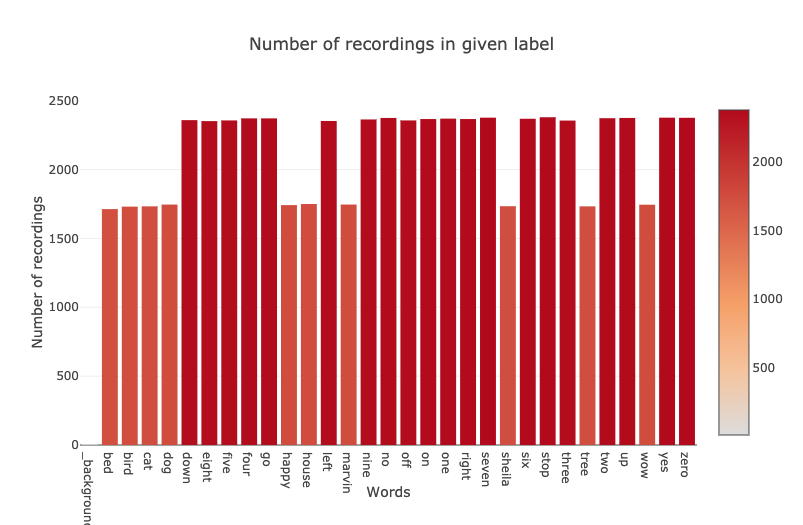

In [ ]:
def extract_features(direct, filename): 
    d = dict() 
    data, sr = librosa.load(f'/content/train/audio/{direct}/{filename}')
    d['mfccs'] = np.mean(librosa.feature.mfcc(y = data, n_fft=250, sr=sr).T, axis = 0)
    d['stft'] = np.abs(librosa.stft(data))
    d['chroma'] = np.mean(librosa.feature.chroma_stft(S = d['stft'], sr = sr).T, axis = 0)
    d['mel'] = np.mean(librosa.feature.melspectrogram(data, sr).T, axis = 0)
    d['contrast'] = np.mean(librosa.feature.spectral_contrast(S = d['stft'], sr = sr).T, axis = 0)
    d['tonnetz'] = np.mean(librosa.feature.tonnetz(y = librosa.effects.harmonic(data), sr = sr).T, axis = 0)
    return d

In [ ]:
data_list = list()
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    number_of_recordings.append(len(waves))
    for filename in waves:
      data_list.append(extract_features(direct, filename))
print(data_list)